## The global warming issue and Narratives around it<br>
### Part 5: Doing further analysis on selected model for insight inferences, ***the real deal !***

In this notebook, I set the stage to infer insights based on logistic regression model and the engineered features.

Importing the required libraries:

In [1]:
#imports
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import eli5

import regex as re
import nltk
#nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, FeatureUnion


from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import StandardScaler, FunctionTransformer


from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score, classification_report


from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier

from nltk.corpus import stopwords

import pickle

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

/Users/smighani/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/smighani/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


## Part 4.1: Importing the saved dataframe and removing the learned stop words

In [2]:
df_reddit = pickle.load(open('../datasets/df_reddit_for_model.pkl', 'rb'))


my_stop_words = ["dec", "global", "http", "www", "com", "conspiraci", "warm", "climat", "remov", "theori", "theactualshadow", "co"]
list_stop_words = nltk.corpus.stopwords.words('english')
list_stop_words.extend(my_stop_words)


def remove_stops(item):

    stops = list_stop_words
    words = [w for w in item.split() if w not in stops]#stops
    
    words = " ".join(list(words)) # Adding space
    
    return words

df_reddit['text_merged'] = df_reddit['text_merged'].apply(remove_stops)




df_reddit.head()

,author,created_utc,id,num_comments,over_18,post_hint,score,text_merged,subreddit,word_count*,sentiment_score*,date,target,reaction*
0,Kafka15,1593554514,hixbtf,2,0,image,1,cum,GlobalWarming,1,0.0000,2020-06-30 22:01:54,1,2
1,karan_negiiiii,1593497051,hihj6s,0,0,Empty,1,chang india,GlobalWarming,3,0.0000,2020-06-30 06:04:11,1,0
2,Hildavardr,1593479932,hidb5h,0,0,Empty,1,respons big compani,GlobalWarming,5,0.2263,2020-06-30 01:18:52,1,0
3,pEppapiGistfuhrer,1593455137,hi5h41,1,0,image,1,ayi let stop,GlobalWarming,5,-0.0772,2020-06-29 18:25:37,1,1
4,BrexitBlaze,1593455005,hi5feq,2,0,link,2,uk minist send mix messag commit say fund mana...,GlobalWarming,13,0.2960,2020-06-29 18:23:25,1,4


## Bootstrapped the under-represented class to balance the classes:

In [3]:
n_bts_sample = df_reddit[(df_reddit["subreddit"]=="GlobalWarming")].shape[0] - df_reddit[(df_reddit["subreddit"]=="ConspiracyTheory")].shape[0]

df_btsp = df_reddit[(df_reddit["subreddit"]=="ConspiracyTheory")].sample(n = n_bts_sample, replace=True, random_state = 101)

df_reddit_btsp = pd.concat([df_reddit, df_btsp])

df_reddit_btsp.reset_index(drop=True, inplace=True)

## Part 4.2- **Logistic Regression**, only on vectorized text (using CountVectorizer)

In [4]:
X = df_reddit_btsp['text_merged']
y = df_reddit_btsp['target']

In [5]:
X.shape

(7868,)

Defining variables

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.25,
                                                    stratify=y,
                                                    random_state = 101)

Checking for stratified target variables:

In [7]:
y.value_counts(normalize=True)

1    0.5
0    0.5
Name: target, dtype: float64

In [8]:
y_train.value_counts(normalize=True)

0    0.500085
1    0.499915
Name: target, dtype: float64

In [9]:
y_test.value_counts(normalize=True)

1    0.500254
0    0.499746
Name: target, dtype: float64

### Baseline accuracy:

In [10]:
y_test.value_counts(normalize=True)

1    0.500254
0    0.499746
Name: target, dtype: float64

Hence, 50%, this is the worst we are allowed to do!

### Vectorizing text data and looking into it:
### Also, training a transformer which will be used on new dataset and pickling it

In [11]:
#Adding a stop word list which I derived from an initial plot:



vectorizer = CountVectorizer(analyzer = "word",
                             #ngram_range=(1,2),
                             tokenizer = None,
                             preprocessor = None,
                             stop_words = list_stop_words,
                             max_features = 3000) 


X_train_features = vectorizer.fit_transform(X_train)

pickle.dump(vectorizer, open('../datasets/vectorizer.pkl', 'wb'))

X_test_features = vectorizer.transform(X_test)

---

# Engineering a new feature: Word-Use-Aggression (WUA) feature:

[WUA] = sum(|distance between top-word indices|)

In [12]:
X_train_features_df = pd.DataFrame(X_train_features.toarray(),
                          columns=vectorizer.get_feature_names())
X_train_features_df.head(2)

,abandon,abil,abl,absolut,absorb,abus,acceler,accept,access,accord,...,youth,youtu,youtub,zag,zealand,zero,zeu,zig,zombi,zone
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [13]:
# get count of top-occurring words

# empty dictionary
top_words = {}

# loop through columns
for i in X_train_features_df.columns:
    # save sum of each column in dictionary
    top_words[i] =  X_train_features_df[i].sum()
    
# top_words to dataframe sorted by highest occurance
most_freq = pd.DataFrame(sorted(top_words.items(), key = lambda x: x[1], reverse = True))
most_freq

,0,1
0,world,1287
1,chang,875
2,like,841
3,peopl,821
4,us,758
...,...,...
2995,wgxcq,8
2996,wheel,8
2997,winner,8
2998,xpost,8


In [14]:
# The cvec parameters obtained from previous gridsearch

cvec = CountVectorizer(stop_words=list_stop_words, min_df=4, max_df=1.0)
term_mat = cvec.fit_transform(df_reddit['text_merged'])
len(cvec.get_feature_names())

term_df = pd.DataFrame(term_mat.toarray(), columns=cvec.get_feature_names())

term_df.insert(0, 'targets', df_reddit["target"])
term_df.head(2)

,targets,ab,abandon,abil,abl,absolut,absorb,absorpt,abstract,absurd,...,york,yorker,young,younger,youth,youtu,youtub,zealand,zero,zone
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
#term_df.groupby('targets').mean().T.sort_values(0, ascending=False).head(20)

In [16]:
top_words_gw = list(term_df.groupby('targets').
     mean().T.sort_values(1, ascending=False).head(100).index)

top_words_ct = list(term_df.groupby('targets').
     mean().T.sort_values(0, ascending=False).head(100).index)

top_words_overlap = [word for word in top_words_gw if word in top_words_ct]

pickle.dump(top_words_overlap, open('../datasets/top_words_overlap.pkl', 'wb'))

In [17]:
top_words_overlap[:20]

['year',
 'earth',
 'world',
 'would',
 'peopl',
 'like',
 'make',
 'use',
 'think',
 'could',
 'time',
 'one',
 'human',
 'know',
 'need',
 'go',
 'say',
 'get',
 'us',
 'thing']

In [18]:
def get_uwa(item):

    words = [w for w in item.split()]
    #print(words)
    
    index_list = []
    distance = []
    for i in range(len(words)):
        
        if (words[i] in list(top_words)):
            index_list.append(i)
    
    if (len(index_list)>0):
        for i in range(len(index_list)):
            distance_sum_i = np.sum(np.abs(np.array(index_list[:]) - np.array(index_list[i])))
            distance.append(distance_sum_i)
    else:
        distance = 0
    
    return np.product(distance)

In [19]:
# Testing the wua algorithm

X = df_reddit["text_merged"][7]


get_uwa(X)
words = [w for w in X.split()]
index_list = []
distance = []
for i in range(len(words)):
        #print(words[i])
        #print((words[i] in list(top_words)))
        if (words[i] in list(top_words)):
            index_list.append(i)
            #print(i)
if (len(index_list)>0):
    for i in range(len(index_list)):
        distance_sum_i = np.sum(np.abs(np.array(index_list[:]) - np.array(index_list[i])))
        distance.append(distance_sum_i)
else:
    distance = 0

print(index_list)
print(X)
print(distance)
print(np.prod(distance))

[0, 2, 3, 4, 5]
extra bn need year report say
[14, 8, 7, 8, 11]
68992


In [20]:
df_reddit['wua*'] = df_reddit['text_merged'].apply(get_uwa)


In [21]:
df_reddit.head(10)

,author,created_utc,id,num_comments,over_18,post_hint,score,text_merged,subreddit,word_count*,sentiment_score*,date,target,reaction*,wua*
0,Kafka15,1593554514,hixbtf,2,0,image,1,cum,GlobalWarming,1,0.0000,2020-06-30 22:01:54,1,2,0
1,karan_negiiiii,1593497051,hihj6s,0,0,Empty,1,chang india,GlobalWarming,3,0.0000,2020-06-30 06:04:11,1,0,1
2,Hildavardr,1593479932,hidb5h,0,0,Empty,1,respons big compani,GlobalWarming,5,0.2263,2020-06-30 01:18:52,1,0,18
3,pEppapiGistfuhrer,1593455137,hi5h41,1,0,image,1,ayi let stop,GlobalWarming,5,-0.0772,2020-06-29 18:25:37,1,1,1
4,BrexitBlaze,1593455005,hi5feq,2,0,link,2,uk minist send mix messag commit say fund mana...,GlobalWarming,13,0.2960,2020-06-29 18:23:25,1,4,500281935462400000
5,ManesJr,1593451635,hi493l,1,0,image,1,mmm ye,GlobalWarming,2,0.0000,2020-06-29 17:27:15,1,1,0
6,-i-love-downvotes-,1593433887,hhyzxy,1,0,image,1,oh yeeaahh,GlobalWarming,2,0.0000,2020-06-29 12:31:27,1,1,0
7,BrexitBlaze,1593425020,hhx644,1,0,link,1,extra bn need year report say,GlobalWarming,7,0.0000,2020-06-29 10:03:40,1,1,68992
8,Robo4575,1593401210,hhsg4o,3,0,link,2,check shirt,GlobalWarming,4,0.2263,2020-06-29 03:26:50,1,6,0
9,ballzy94,1593370971,hhk71m,0,0,rich:video,1,technolog protect tree,GlobalWarming,3,0.3818,2020-06-28 19:02:51,1,0,18


In [22]:
df_reddit.describe().T

,count,mean,std,min,25%,50%,75%,max
created_utc,4828.0,1.502680e+09,7.143753e+07,1.223801e+09,1.448448e+09,1.521834e+09,1.564223e+09,1.593555e+09
num_comments,4828.0,1.926471e+00,4.711545e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00,8.200000e+01
over_18,4828.0,4.142502e-04,2.035103e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
score,4828.0,2.860191e+00,5.042242e+00,0.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,5.400000e+01
word_count*,4828.0,2.162158e+01,5.753280e+01,1.000000e+00,5.000000e+00,8.000000e+00,1.400000e+01,1.381000e+03
sentiment_score*,4828.0,3.338496e-02,4.111235e-01,-9.979000e-01,-1.090250e-01,0.000000e+00,2.263000e-01,9.987000e-01
target,4828.0,8.148302e-01,3.884755e-01,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
reaction*,4828.0,1.032684e+01,4.870632e+01,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00,1.062000e+03
wua*,4828.0,-3.686857e+16,2.390912e+18,-9.223372e+18,1.000000e+00,1.575000e+03,7.120386e+08,9.128476e+18


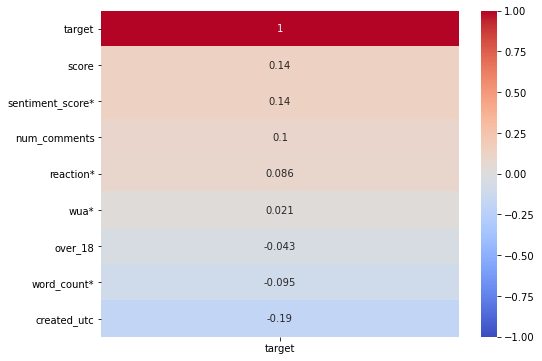

In [23]:
df_reddit_corr = df_reddit.corr()

#plt.figure(figsize=(6,6))
plt.figure(figsize=(8,6))
sns.heatmap(df_reddit_corr[['target']].sort_values(by=['target'],ascending=False),
            vmin=-1,
            cmap='coolwarm',
            annot=True);
plt.savefig("../plots/EDA_corr_plots.png")

---

### Now, instantiating the logistic regression model and fitting:

In [24]:
#Instantiating the model:
lr = LogisticRegression(solver='newton-cg')

In [25]:
lr.fit(X_train_features, y_train);

pickle.dump(lr, open('../datasets/lr.pkl', 'wb'))



In [26]:
lr.score(X_train_features, y_train)

0.9762752075919335

In [27]:
lr.score(X_test_features, y_test)



0.9445856634468734

In [28]:
preds = lr.predict(X_test_features)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

# View confusion matrix

#plot_confusion_matrix(gs, X_test_features, y_test, cmap='Blues', values_format='d');

Accuracy = (tp + tn) / (tp + tn + fp + fn)
Precision = tp / (tp + fp)
Recall = tp / (tp + fn)

Accuracy, Precision, Recall

(0.9445856634468734, 0.9524301964839711, 0.9359756097560976)

Creating a dataframe to look at the coefficient of the base model:

In [29]:
df_coeffs = pd.DataFrame()
df_coef= pd.DataFrame(lr.coef_).T
df_feat = pd.DataFrame(vectorizer.get_feature_names())

df_lr_coefs=pd.concat([df_feat, df_coef], axis=1)
df_lr_coefs.columns = ["feature_names", "LR_coefficients"]
df_lr_coefs_sorted = df_lr_coefs.sort_values(by =["LR_coefficients"], ascending=False, ignore_index=True)
df_lr_coefs_sorted.tail(20)

,feature_names,LR_coefficients
2980,media,-1.604773
2981,decid,-1.610085
2982,score,-1.627026
2983,april,-1.674951
2984,control,-1.687845
2985,mark,-1.698292
2986,capitalist,-1.715126
2987,cryptid,-1.725554
2988,men,-1.727126
2989,revolutionari,-1.730522


In [30]:
df_lr_coefs_sorted.head(20)

,feature_names,LR_coefficients
0,chang,2.678162
1,carbon,2.199971
2,environment,1.960876
3,scientist,1.915648
4,emiss,1.856226
5,temperatur,1.687181
6,ice,1.637795
7,futur,1.583468
8,environ,1.561237
9,green,1.544157


## Part 4.3- **Logistic Regression** <br><br>(only on vectorized text, vectorized by TF-IDF vectorizer)

In [31]:
# Instantiate the transformer.
tvec = TfidfVectorizer()

In [32]:
df = pd.DataFrame(tvec.fit_transform(X_train).toarray(),
                  columns=tvec.get_feature_names())
df.head()

,aa,aacgtmjui,aaliyah,aaron,aass,ab,aback,abandon,abbott,abbrevi,...,zombi,zone,zoo,zorgt,zq,zr,ztiu,zuckerberg,zvhm,zwhvc
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Designing a pipeline for TF-IDF analysis

In [33]:
# Set up a pipeline with tf-idf vectorizer and multinomial naive bayes

pipe_tvec = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

In [34]:
# Search over the following values of hyperparameters:
# Maximum number of features fit: 2000, 3000, 4000, 5000
# No stop words and english stop words
# Check (individual tokens) and also check (individual tokens and 2-grams).

pipe_tvec_params = {
    'tvec__max_features': [2_000, 3_000, 4_000, 5_000],
    'tvec__stop_words': [list_stop_words, 'english'],
    'tvec__ngram_range': [(1,1), (1,2)]
}

In [35]:
# Instantiate GridSearchCV.

gs = GridSearchCV(pipe_tvec, # what object are we optimizing?
                        param_grid = pipe_tvec_params, # what parameters values are we searching?
                        cv=5) # 5-fold cross-validation.

In [36]:
# Fit GridSearch to training data.
gs.fit(X_train, y_train);

In [37]:
# Score model on training set.
gs.score(X_train, y_train)

0.9481443823080834

In [38]:
# Score model on testing set.
gs.score(X_test, y_test)

0.9145907473309609

In [39]:
preds = lr.predict(X_test_features)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

# View confusion matrix

#plot_confusion_matrix(gs, X_test_features, y_test, cmap='Blues', values_format='d');

Accuracy = (tp + tn) / (tp + tn + fp + fn)
Precision = tp / (tp + fp)
Recall = tp / (tp + fn)

Accuracy, Precision, Recall

(0.9445856634468734, 0.9524301964839711, 0.9359756097560976)

## Part 4.4- **Logistic Regression** <br><br> (on numeric and text data)

Designing the pipeline:

In [40]:
df_reddit

,author,created_utc,id,num_comments,over_18,post_hint,score,text_merged,subreddit,word_count*,sentiment_score*,date,target,reaction*,wua*
0,Kafka15,1593554514,hixbtf,2,0,image,1,cum,GlobalWarming,1,0.0000,2020-06-30 22:01:54,1,2,0
1,karan_negiiiii,1593497051,hihj6s,0,0,Empty,1,chang india,GlobalWarming,3,0.0000,2020-06-30 06:04:11,1,0,1
2,Hildavardr,1593479932,hidb5h,0,0,Empty,1,respons big compani,GlobalWarming,5,0.2263,2020-06-30 01:18:52,1,0,18
3,pEppapiGistfuhrer,1593455137,hi5h41,1,0,image,1,ayi let stop,GlobalWarming,5,-0.0772,2020-06-29 18:25:37,1,1,1
4,BrexitBlaze,1593455005,hi5feq,2,0,link,2,uk minist send mix messag commit say fund mana...,GlobalWarming,13,0.2960,2020-06-29 18:23:25,1,4,500281935462400000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4823,[deleted],1349719843,115d9u,0,0,Empty,0,us air forc superson fli saucer declassifi,ConspiracyTheory,7,0.0000,2012-10-08 18:10:43,0,0,228953088
4824,[deleted],1348231298,108ubr,0,0,Empty,1,dae think sin ruin r fascist totalitarian pers...,ConspiracyTheory,81,-0.9857,2012-09-21 12:41:38,0,0,-5764607523034234880
4825,[deleted],1347716678,zxb87,1,0,Empty,9,subreddit empti,ConspiracyTheory,3,0.0000,2012-09-15 13:44:38,0,9,1
4826,aayawa,1344626686,y0fkg,3,0,Empty,0,one world govern possibl stabl,ConspiracyTheory,5,0.0000,2012-08-10 19:24:46,0,0,29400


Step 1: defining transformers:

In [41]:
#Sele3cting selecetd columns
sel_numer_columns = ["score", "word_count*", "sentiment_score*", "reaction*", "wua*"]

# create functions to return just the columns that you care about
get_text_data= FunctionTransformer(lambda x: x['text_merged'], validate = False)
get_numeric_data = FunctionTransformer(lambda x: x[sel_numer_columns], validate = False)

In [42]:
X = df_reddit[["text_merged", "score", "word_count*", "sentiment_score*", "reaction*", "wua*"]]
y = df_reddit['target']

np.random.seed(42)

X_train, X_test, y_train, y_test = train_test_split(X,y)

Pipe 3: Scale the numeric

In [43]:
pipe_v3 = Pipeline([
    ('features', FeatureUnion([
            ('numeric_features', Pipeline([
                ('selector', get_numeric_data),
                ('ss', StandardScaler())
            ])),
            ('text_features', Pipeline([
                ('selector', get_text_data),
                ('cvec', CountVectorizer())
            ]))
    ])),
    ('logreg', LogisticRegression())
])

params = {
            #'cvec__stop_words' : [list_stop_words, 'english'],
           'logreg__penalty' : ['l1', 'l2']
}

gs = GridSearchCV(pipe_v3, params, cv=5)

gs.fit(X_train, y_train)
gs.score(X_train, y_train)



0.9784589892294946

In [44]:
print(gs.score(X_train, y_train))
print(gs.score(X_test, y_test))

0.9784589892294946
0.908036454018227


In [45]:
def nice_conmat(y_test, preds, classes):

    conmat = confusion_matrix(y_test, preds)
    print(f'Accuracy Score: {accuracy_score(y_test, preds)}')
    return pd.DataFrame(conmat, columns=['Predicted ' +class_ for class_ in classes], \
                index=['Actual '+ class_ for class_ in classes])

In [46]:
# build a function to print out a nice confusion matrix
preds = gs.best_estimator_.predict(X_test)

nice_conmat(y_test, preds, ['consp', 'globalwarming'])

Accuracy Score: 0.908036454018227


,Predicted consp,Predicted globalwarming
Actual consp,128,102
Actual globalwarming,9,968


In [47]:
#coefficients
coefficients = gs.best_estimator_.named_steps['logreg'].coef_[0]

In [48]:
# Best model in gridsearchCV
# Object is a Pipeline
gs.best_estimator_

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('numeric_features',
                                                 Pipeline(steps=[('selector',
                                                                  FunctionTransformer(func=<function <lambda> at 0x7f9d81b00320>)),
                                                                 ('ss',
                                                                  StandardScaler())])),
                                                ('text_features',
                                                 Pipeline(steps=[('selector',
                                                                  FunctionTransformer(func=<function <lambda> at 0x7f9d81b00200>)),
                                                                 ('cvec',
                                                                  CountVectorizer())]))])),
                ('logreg', LogisticRegression())])

In [49]:
features = gs.best_estimator_.named_steps['features'].transformer_list[1][1].named_steps['cvec'].get_feature_names()

In [50]:
features = sel_numer_columns +\
gs.best_estimator_.named_steps['features'].transformer_list[1][1].named_steps['cvec'].get_feature_names()

# no changes to our coefficient variable:
# I'm just bringing it down here
coefficients = gs.best_estimator_.named_steps['logreg'].coef_[0]

In [51]:
coef_df = pd.DataFrame({'features': features, 
              'coef' : coefficients,
              'exp_coef': [np.exp(coef) for coef in coefficients] #exponentiated coefficients
             })

coef_df.head(10)

,features,coef,exp_coef
0,score,0.627701,1.873299
1,word_count*,-1.536282,0.215180
2,sentiment_score*,0.614462,1.848662
3,reaction*,0.782491,2.186913
4,wua*,0.075228,1.078130
5,aa,0.000120,1.000120
6,aaaaaaacixu,0.000001,1.000001
7,aacgtmjui,-0.000163,0.999837
8,aaliyah,-0.000163,0.999837
9,aass,0.000512,1.000513


### Interpretation: The numerical columns do not seem to make much improvement on the score.

### Plotting important features

In [52]:
coef_df = coef_df.set_index('features')
coef_df = coef_df.sort_values('exp_coef', ascending = False)
coef_df.head(10)

,coef,exp_coef
features,,
chang,2.500275,12.185850
carbon,1.582457,4.866898
scientist,1.502707,4.493837
ice,1.338620,3.813779
stop,1.303841,3.683417
temperatur,1.292707,3.642635
environment,1.254234,3.505152
environ,1.166261,3.209968
emiss,1.087576,2.967073


In [53]:
coef_df['exp_coef'].head(10).sort_values()

features
warn            2.922015
emiss           2.967073
environ         3.209968
environment     3.505152
temperatur      3.642635
stop            3.683417
ice             3.813779
scientist       4.493837
carbon          4.866898
chang          12.185850
Name: exp_coef, dtype: float64

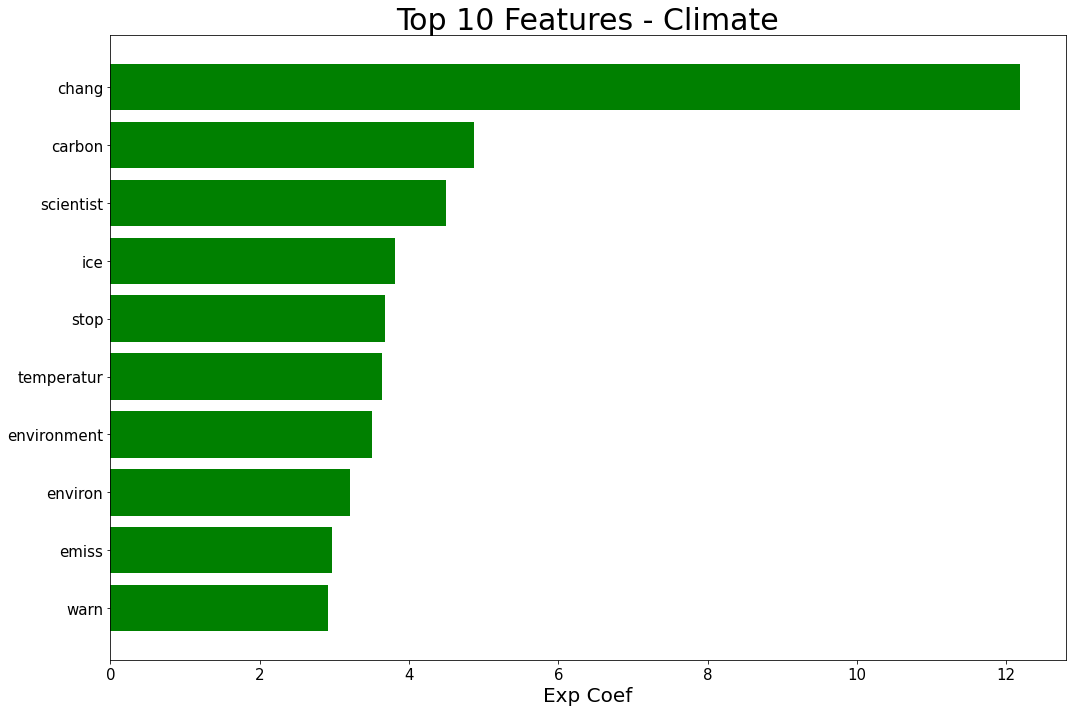

In [54]:
weights = coef_df['exp_coef'].head(10).sort_values()
labels = weights.index

plt.figure(figsize=(15,10))
plt.barh(labels, weights, color = 'green')
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.xlabel('Exp Coef', fontsize=20)
plt.title(f'Top 10 Features - Climate', fontsize=30)
plt.tight_layout()



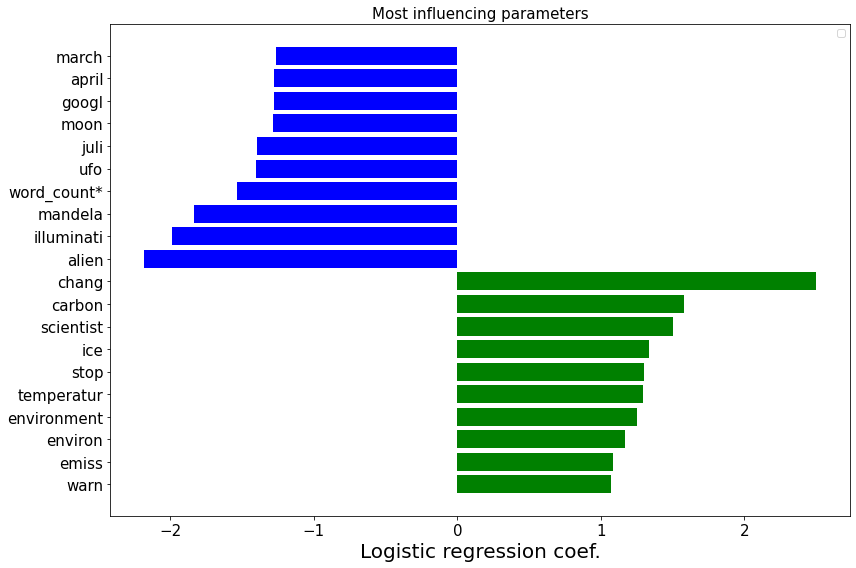

In [55]:
weights = coef_df['coef'].head(10).sort_values()
labels = weights.index

plt.figure(figsize=(12,8))
plt.barh(labels, weights, color = 'green')
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.xlabel('Logistic regression coef.', fontsize=20)
plt.title(f'Most influencing parameters', fontsize=15)



weights = coef_df['coef'].tail(10).sort_values()
labels = weights.index


plt.barh(labels, weights, color = 'blue')
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)

plt.tight_layout()

plt.legend("positively correlated", "negatively correlated")


plt.savefig("../plots/Ranking_top_bottom.png")

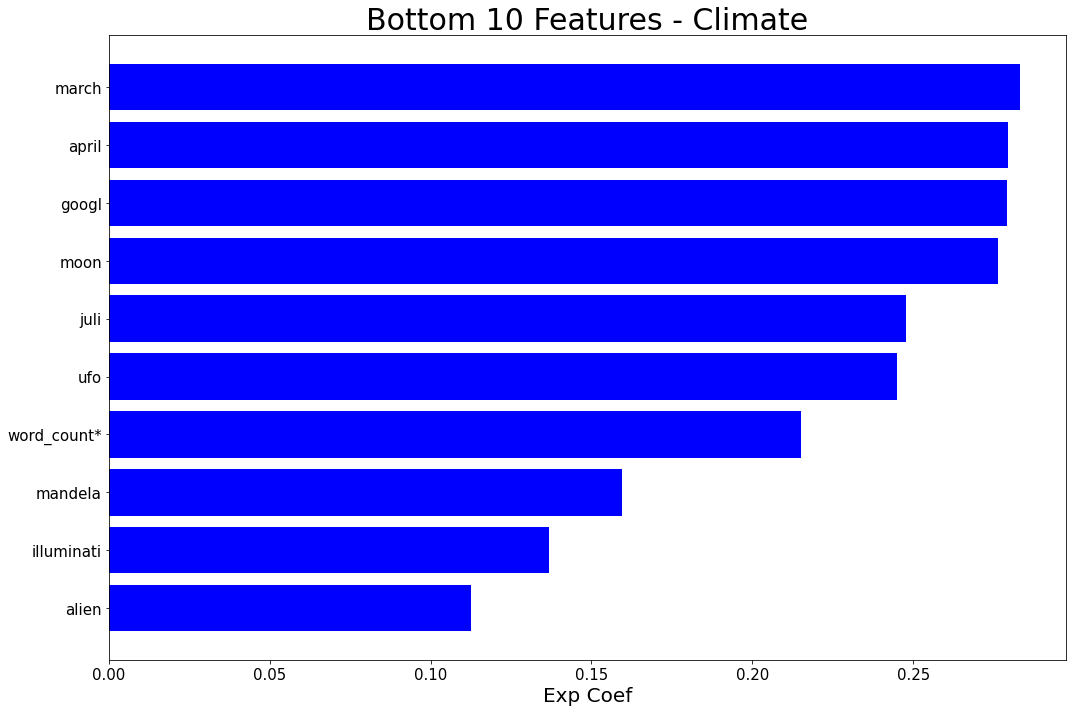

In [56]:
weights = coef_df['exp_coef'].tail(10).sort_values()
labels = weights.index

plt.figure(figsize=(15,10))
plt.barh(labels, weights, color = 'blue')
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.xlabel('Exp Coef', fontsize=20)
plt.title(f'Bottom 10 Features - Climate', fontsize=30)
plt.tight_layout()

plt.savefig("../plots/Ranking_bottom.png")

## Plotting the time-series data of word usage

In [57]:
def token_time_series(item):

    words = [w for w in item.split()]
    #print(words)
    
    token_count = 0
    
    for word in words:
        
        if (word == key_word):
            token_count += 1
    
    return token_count

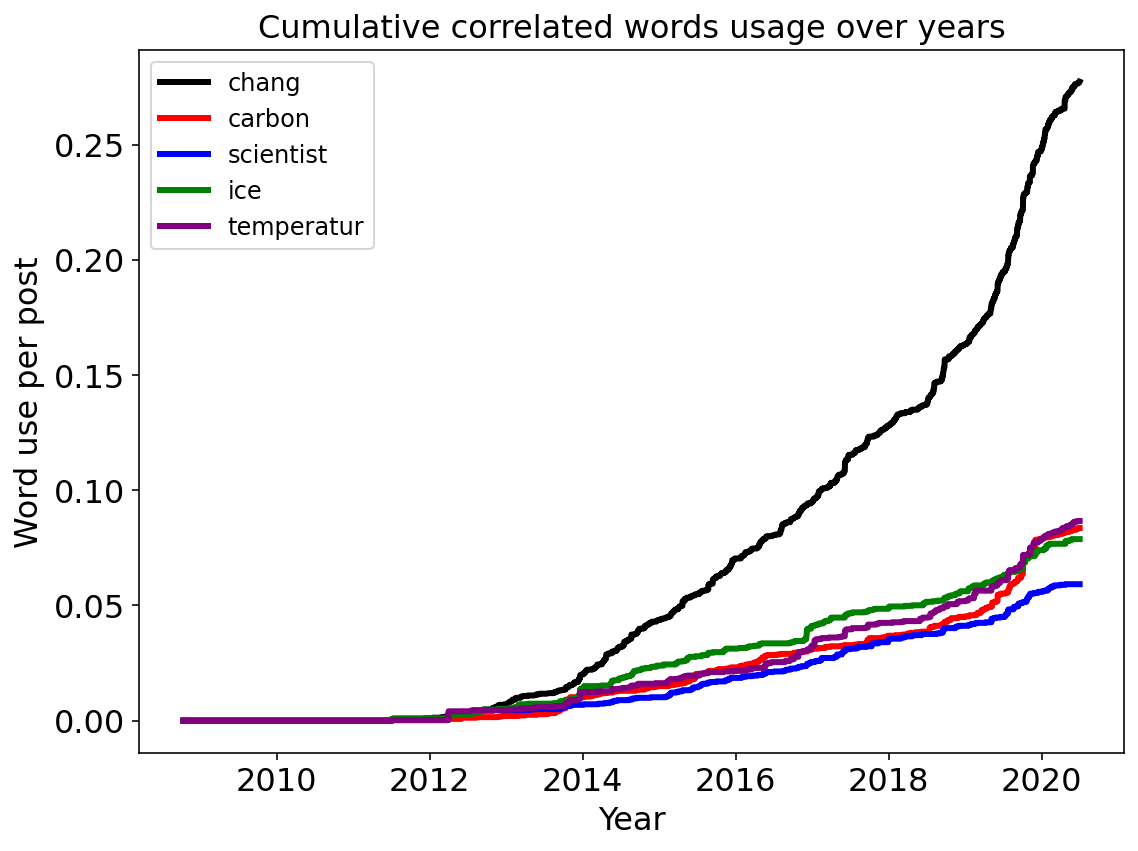

In [58]:
%config InlineBackend.figure_format = 'retina'


gw_post_num = 3934


plt.figure(figsize=(8,6))


weights = coef_df['exp_coef'].head(10).sort_values()
labels = weights.index

color = ["black", "red", "blue", "green", "purple"]

for i, label in enumerate(["chang", "carbon", "scientist", "ice", "temperatur"]):
    key_word = label
    df_reddit_test = df_reddit.copy()
        
    df_reddit_test.sort_values("date", axis = 0, ascending = False, 
                 inplace = True) 
    
    
    df_reddit_test['token_count'] = df_reddit_test['text_merged'].map(token_time_series)

    df_reddit_test['token_count_cum'] = df_reddit_test["token_count"].cumsum()
    df_reddit_test['token_count_cum'] = np.max(df_reddit_test['token_count_cum']) - df_reddit_test['token_count_cum']

    df_reddit_test = df_reddit_test.set_index('date')
    plt.plot(df_reddit_test['token_count_cum'] / gw_post_num, color = color[i], linewidth = 3)
    
#plt.xlim(2010, 2021)    
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.xlabel('Year', fontsize=16)
plt.ylabel('Word use per post', fontsize=16)

plt.title('Cumulative correlated words usage over years', fontsize=16)

plt.legend(["chang", "carbon", "scientist", "ice", "temperatur"], fontsize = 12)
plt.tight_layout()

#Gtreta thungberg 21/09/2019

#plt.vlines(x = np.mean(dataframe[column]), ymin = 0, ymax = np.max((np.histogram(dataframe[column]))[0]), color = 'green', linewidth = 5, alpha = 0.6)
#ax[i].text(np.mean(dataframe[column]), np.max((np.histogram(dataframe[column]))[0]), f'mean={round(np.mean(dataframe[column]), 1)}', color = 'green')
        
plt.savefig("../plots/Word_use_top.png")


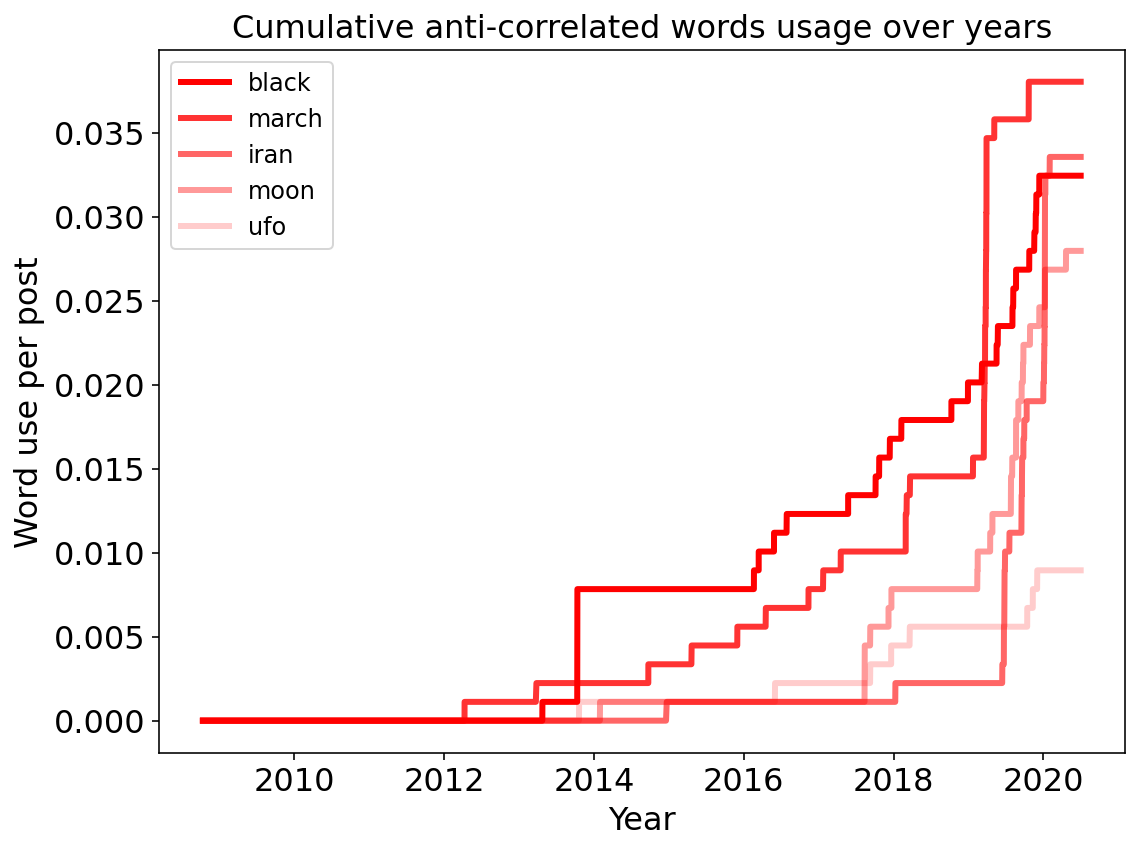

In [59]:
%config InlineBackend.figure_format = 'retina'


plt.figure(figsize=(8,6))

ct_post_num = 894

weights = coef_df['exp_coef'].head(10).sort_values()
labels = weights.index

#color = ["black", "red", "blue", "green", "purple"]
alpha_ = [1, 0.8, 0.6, 0.4, 0.2]

for i, label in enumerate(["black", "march", "iran", "moon", "ufo"]):
    key_word = label
    df_reddit_test = df_reddit.copy()
        
    df_reddit_test.sort_values("date", axis = 0, ascending = False, 
                 inplace = True) 
    
    
    df_reddit_test['token_count'] = df_reddit_test['text_merged'].map(token_time_series)

    df_reddit_test['token_count_cum'] = df_reddit_test["token_count"].cumsum()
    df_reddit_test['token_count_cum'] = np.max(df_reddit_test['token_count_cum']) - df_reddit_test['token_count_cum']

    df_reddit_test = df_reddit_test.set_index('date')
    plt.plot(df_reddit_test['token_count_cum'] / ct_post_num, color = 'red', alpha = alpha_[i], linewidth = 3)
    
#plt.xlim(2010, 2021)    
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.xlabel('Year', fontsize=16)
plt.ylabel('Word use per post', fontsize=16)


plt.title('Cumulative anti-correlated words usage over years', fontsize=16)

plt.legend(["black", "march", "iran", "moon", "ufo"], fontsize = 12)
plt.tight_layout()

#Gtreta thungberg 21/09/2019

#plt.vlines(x = np.mean(dataframe[column]), ymin = 0, ymax = np.max((np.histogram(dataframe[column]))[0]), color = 'green', linewidth = 5, alpha = 0.6)
#ax[i].text(np.mean(dataframe[column]), np.max((np.histogram(dataframe[column]))[0]), f'mean={round(np.mean(dataframe[column]), 1)}', color = 'green')
        
plt.savefig("../plots/Word_use_low.png")



In [60]:
print("Hello world!")

Hello world!
